In [1]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
source_images = '/kaggle/input/pothole-detection/images'
source_annots = '/kaggle/input/pothole-detection/annotations'

all_images = [f for f in os.listdir(source_images) if f.endswith('.png')]
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

splits = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

for split, files in splits.items():
    os.makedirs(f'/kaggle/working/dataset/{split}/images', exist_ok=True)
    os.makedirs(f'/kaggle/working/dataset/{split}/labels', exist_ok=True)

In [4]:
def convert_annotation(xml_file, txt_file, image_size):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    w, h = image_size
    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name != 'pothole':
                continue
            xmlbox = obj.find('bndbox')
            xmin = float(xmlbox.find('xmin').text)
            ymin = float(xmlbox.find('ymin').text)
            xmax = float(xmlbox.find('xmax').text)
            ymax = float(xmlbox.find('ymax').text)
            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            box_w = (xmax - xmin) / w
            box_h = (ymax - ymin) / h
            f.write(f"0 {x_center} {y_center} {box_w} {box_h}\n")

In [5]:
for split, file_list in splits.items():
    for file in file_list:
        base = os.path.splitext(file)[0]
        img_src = os.path.join(source_images, file)
        xml_src = os.path.join(source_annots, f"{base}.xml")
        img_dst = f'/kaggle/working/dataset/{split}/images/{file}'
        txt_dst = f'/kaggle/working/dataset/{split}/labels/{base}.txt'
        shutil.copy(img_src, img_dst)
        with Image.open(img_src) as img:
            convert_annotation(xml_src, txt_dst, img.size)

In [6]:
with open('/kaggle/working/dataset/data.yaml', 'w') as f:
    f.write("train: /kaggle/working/dataset/train/images\n")
    f.write("val: /kaggle/working/dataset/val/images\n")
    f.write("test: /kaggle/working/dataset/test/images\n")
    f.write("nc: 1\n")
    f.write("names: ['pothole']\n")

In [7]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
model.train(
    data='/kaggle/working/dataset/data.yaml',
    epochs=250,
    imgsz=640,
    project='/kaggle/working/runs',
    name='pothole_yolov8n'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.164 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, kera

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 121MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2747.0±1051.8 MB/s, size: 633.6 KB)


train: Scanning /kaggle/working/dataset/train/labels... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<00:00, 507.67it/s]

train: New cache created: /kaggle/working/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1580.7±1417.7 MB/s, size: 505.6 KB)


val: Scanning /kaggle/working/dataset/val/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 376.59it/s]

val: New cache created: /kaggle/working/dataset/val/labels.cache


Plotting labels to /kaggle/working/runs/pothole_yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/pothole_yolov8n
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      2.28G      3.865      3.956      4.197          4        640: 100%|██████████| 30/30 [00:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        100        260    0.00203      0.223    0.00153   0.000559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      2.55G      3.468      3.659      3.916          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        100        260    0.00213      0.231    0.00191   0.000599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      2.57G      3.144      3.427      3.494         15        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        100        260    0.00305      0.131    0.00246   0.000802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      2.59G      3.006      3.254      3.212          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

                   all        100        260     0.0123       0.05      0.004    0.00119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      2.61G      2.879      3.182      3.075          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all        100        260     0.0434     0.0385     0.0166     0.0044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      2.62G      2.755      3.036      2.915          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all        100        260     0.0468      0.112     0.0246    0.00661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      2.64G      2.697      2.898      2.855          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        100        260      0.146       0.15     0.0586     0.0181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      2.66G      2.632      2.843      2.779          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        100        260     0.0845        0.2     0.0453     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      2.67G      2.581      2.736      2.721          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

                   all        100        260      0.193      0.131     0.0703     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      2.69G      2.494      2.672      2.665          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

                   all        100        260      0.193      0.104     0.0772     0.0313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      2.71G      2.414      2.604      2.599          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        100        260       0.21      0.162      0.107     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      2.72G      2.372      2.576      2.549          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        100        260      0.214      0.146     0.0863     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      2.74G      2.356      2.568      2.514          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        100        260      0.138      0.208     0.0916      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      2.76G      2.338      2.467      2.471          4        640: 100%|██████████| 30/30 [00:06<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all        100        260      0.254      0.327      0.186     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      2.78G      2.258      2.408      2.412          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        100        260      0.157      0.204      0.108     0.0464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      2.79G      2.207      2.357      2.401          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all        100        260       0.24      0.265      0.167      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      2.81G      2.178      2.339      2.375          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        100        260        0.4      0.304      0.283      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      2.83G      2.165      2.231      2.288         14        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        100        260      0.405        0.3      0.303      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      2.84G      2.097      2.246      2.295          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

                   all        100        260      0.417        0.4      0.335      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      2.86G      2.094      2.136      2.236         12        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        100        260      0.317        0.3      0.235     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      2.88G       2.01      2.109      2.226          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        100        260       0.41      0.369      0.327      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250       2.9G      2.007      2.124      2.233          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        100        260      0.387      0.392      0.329       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      2.91G      2.009      2.087      2.197          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all        100        260      0.435      0.346      0.309      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      2.93G      2.011      2.077      2.169          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

                   all        100        260      0.475       0.35      0.383      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      2.95G      1.972      2.114      2.169          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        100        260      0.447      0.408      0.381      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      2.96G      1.924      2.037      2.104          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        100        260      0.496      0.412      0.424      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      2.98G      1.905      1.957      2.094          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        100        260      0.495      0.388      0.394      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250         3G      1.908      1.917      2.061         12        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

                   all        100        260      0.349      0.438      0.346      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      3.02G      1.866      1.862      2.033          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        100        260      0.579      0.486      0.516      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      3.03G       1.82      1.894      2.024          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

                   all        100        260      0.501      0.447       0.45      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      3.05G      1.804      1.835       2.02          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.64it/s]

                   all        100        260      0.509      0.502      0.497      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      3.07G      1.861      1.844      2.038          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

                   all        100        260      0.584      0.465      0.512      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      3.08G      1.803      1.832      2.007          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        100        260      0.579      0.513      0.526      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250       3.1G      1.818      1.845      2.055          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all        100        260      0.613      0.465       0.51       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      3.12G      1.775      1.754      1.958          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        100        260      0.656      0.458       0.52      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      3.14G      1.782      1.767      1.946         14        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        100        260      0.646      0.527      0.554      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      3.15G      1.758      1.719      1.912          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        100        260      0.599      0.519      0.557      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      3.17G      1.747      1.716      1.909          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

                   all        100        260      0.621      0.473      0.511      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      3.19G      1.732       1.78      1.954          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all        100        260      0.654      0.509      0.572      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250       3.2G       1.71      1.691      1.933          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260      0.592      0.523      0.532      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      3.22G      1.714      1.669      1.918          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100        260      0.736      0.519      0.618      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      3.24G      1.674      1.611      1.863          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

                   all        100        260      0.658      0.508      0.574      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      3.25G       1.68       1.65      1.885          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        100        260      0.562      0.519       0.55      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      3.27G       1.67      1.677      1.894          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        100        260      0.645      0.458      0.583       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      3.29G       1.73       1.63      1.909          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

                   all        100        260       0.64      0.569      0.607      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      3.31G      1.639      1.597      1.837          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        100        260      0.669      0.574      0.618      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      3.32G      1.628      1.559      1.824          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all        100        260      0.637      0.507      0.549      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      3.34G      1.632      1.559       1.81          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

                   all        100        260      0.687      0.585      0.643      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      3.36G      1.573      1.746      1.748          0        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]

                   all        100        260      0.666      0.535       0.58      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      3.37G      1.658      1.533      1.855          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

                   all        100        260      0.715       0.54      0.636      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      3.39G      1.638      1.498      1.811          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        100        260      0.655      0.619      0.646      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      3.41G      1.621      1.535      1.819          9        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100        260       0.73      0.546      0.639      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      3.42G      1.604      1.515      1.817          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

                   all        100        260        0.7      0.569      0.611      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      3.44G      1.583       1.46      1.758         14        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all        100        260      0.656      0.488       0.55      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      3.46G      1.598      1.529      1.811          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260       0.59      0.569      0.583      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      3.48G      1.595      1.465      1.775          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        100        260      0.659      0.581      0.657      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      3.49G      1.563      1.494      1.783          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all        100        260      0.684       0.55      0.627      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      3.51G      1.585      1.507      1.778          5        640: 100%|██████████| 30/30 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

                   all        100        260      0.615      0.577      0.632      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      3.53G      1.597      1.484      1.737          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        100        260        0.7      0.635       0.68      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      3.54G      1.557      1.499      1.752          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all        100        260      0.679      0.608      0.673      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      3.56G      1.596      1.521      1.788          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

                   all        100        260      0.728      0.608       0.68      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      3.58G      1.564      1.428      1.755         10        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all        100        260      0.725      0.604      0.669      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250       3.6G      1.579      1.447      1.768          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all        100        260       0.65      0.573      0.608       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      3.61G      1.535      1.416       1.76          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

                   all        100        260      0.744      0.569      0.672      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      3.63G      1.546      1.426      1.726          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all        100        260      0.688      0.629      0.688      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      3.65G      1.536      1.388      1.706          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100        260      0.757      0.604      0.701      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      3.66G      1.498      1.366      1.686          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all        100        260      0.768      0.608      0.695      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      3.68G      1.549      1.427      1.769          6        640: 100%|██████████| 30/30 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        100        260      0.764      0.558      0.673      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250       3.7G      1.527      1.379       1.69          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        100        260      0.712      0.646      0.704      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      3.71G      1.508      1.337      1.705          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

                   all        100        260      0.768      0.597      0.685      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      3.73G      1.502      1.355      1.682         10        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

                   all        100        260      0.668      0.654      0.696      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      3.75G      1.454      1.312      1.684          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        100        260      0.758      0.573      0.682      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      3.77G      1.464      1.285      1.666          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        100        260      0.744      0.646      0.721       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      3.79G      1.462      1.305      1.659         18        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        100        260      0.773      0.602      0.709      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250       3.8G      1.496      1.345      1.705          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        100        260       0.74      0.546      0.644      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      3.82G      1.473      1.262      1.653          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

                   all        100        260      0.706      0.636      0.704       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      3.83G      1.482      1.292      1.683          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

                   all        100        260      0.729      0.621      0.695      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      3.85G      1.452      1.299      1.629         12        640: 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

                   all        100        260      0.723      0.662       0.72      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      3.87G      1.439      1.277      1.625          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

                   all        100        260      0.761      0.558      0.678      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      3.89G      1.422      1.257      1.641         10        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260      0.728      0.673      0.742      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250       3.9G      1.412      1.227      1.609          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all        100        260      0.703      0.677      0.718      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      3.92G      1.424      1.244      1.649          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all        100        260      0.744      0.627      0.712      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      3.94G      1.452      1.352      1.659          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        100        260      0.761       0.65       0.73      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      3.96G      1.458      1.306      1.681          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        100        260      0.759      0.585      0.702      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      3.97G      1.425      1.227      1.574         17        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        100        260      0.782      0.627      0.736       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      3.99G      1.435      1.249      1.654         11        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

                   all        100        260       0.73      0.658      0.724      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      4.01G      1.447      1.237      1.642          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all        100        260      0.757      0.631      0.708      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      4.02G      1.435      1.291      1.623          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all        100        260       0.75      0.592      0.685      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      4.04G      1.383       1.25      1.619          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]

                   all        100        260      0.735      0.631      0.713      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      4.06G      1.371      1.196      1.609          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all        100        260      0.677      0.654      0.711      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      4.07G      1.417      1.257      1.626          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]

                   all        100        260      0.764      0.634      0.737      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      4.09G      1.414      1.263       1.64          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

                   all        100        260      0.689      0.682      0.718       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      4.11G      1.379      1.205      1.595          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

                   all        100        260      0.728      0.659      0.731      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      4.12G      1.331      1.154      1.562          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

                   all        100        260      0.732      0.619      0.694      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      4.14G      1.381      1.186      1.563         13        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        100        260      0.693      0.667       0.72      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      4.16G      1.363      1.134      1.564          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        100        260      0.723      0.671       0.72      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      4.18G      1.367      1.177      1.589          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        100        260      0.709      0.654      0.721      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250       4.2G       1.33       1.15      1.542          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all        100        260      0.695       0.65      0.702       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      4.21G      1.319      1.172      1.558          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        100        260      0.751      0.638      0.726      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      4.23G      1.373      1.139      1.566          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]

                   all        100        260      0.764       0.65      0.735      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      4.25G      1.323      1.151      1.548          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

                   all        100        260       0.74      0.657      0.745      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      4.26G      1.327      1.146      1.537          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        100        260      0.758      0.662      0.731      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      4.28G      1.358      1.133      1.533          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        100        260      0.803       0.58      0.699      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250       4.3G      1.355      1.162       1.56          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]

                   all        100        260      0.796      0.577      0.711      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      4.31G      1.295      1.101      1.527          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

                   all        100        260      0.709      0.684       0.72      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      4.33G      1.329      1.094      1.557          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        100        260      0.763      0.679      0.755      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      4.35G      1.306      1.076      1.529          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

                   all        100        260      0.717      0.693      0.736      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      4.36G      1.304      1.123      1.544          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        100        260      0.802      0.608      0.716      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      4.38G      1.339      1.111      1.577          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        100        260      0.763       0.65      0.696      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250       4.4G      1.314      1.114       1.54          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]

                   all        100        260      0.629      0.647       0.68      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      4.42G      1.301      1.104      1.528          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

                   all        100        260      0.749      0.619      0.723      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      4.43G      1.316      1.071      1.524          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        100        260      0.767      0.658      0.743      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      4.45G        1.3      1.142      1.544          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        100        260      0.625      0.631      0.649      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      4.47G      1.301      1.098      1.533          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

                   all        100        260      0.709      0.664      0.731      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      4.48G      1.289      1.073      1.494          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260      0.721      0.677      0.721       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250       4.5G      1.324      1.102      1.537         11        640: 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        100        260      0.708      0.681      0.733      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      4.52G      1.327      1.089      1.536          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        100        260      0.763      0.669      0.757      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      4.54G      1.348      1.095      1.591          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        100        260      0.748      0.677      0.734      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      4.55G      1.334      1.102      1.576          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100        260      0.692      0.649      0.724      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      4.57G      1.282      1.059      1.471          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all        100        260       0.78      0.667      0.767      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      4.59G      1.347      1.075      1.552          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

                   all        100        260       0.78      0.585      0.704      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250       4.6G      1.338      1.102      1.559          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

                   all        100        260      0.742      0.669      0.727      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      4.62G      1.243      1.031      1.496          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260      0.772      0.702      0.775      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      4.64G      1.265      1.043      1.506          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

                   all        100        260      0.818      0.627      0.745      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      4.65G      1.283      1.043      1.507          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        100        260      0.704      0.677      0.688      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      4.67G       1.25       1.02      1.465          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

                   all        100        260      0.767      0.692      0.749      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      4.69G      1.247      1.045      1.502          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all        100        260      0.779      0.646      0.744      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      4.71G      1.244      1.018      1.481          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.94it/s]

                   all        100        260      0.741      0.669      0.742      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      4.72G       1.26      1.039      1.477          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]

                   all        100        260      0.766      0.669      0.753       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      4.74G      1.272      1.032      1.453          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        100        260      0.713      0.677      0.734      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      4.76G       1.22      1.006      1.462          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all        100        260      0.824      0.627      0.746      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      4.77G      1.219     0.9881      1.453          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        100        260      0.777      0.642      0.738      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      4.79G      1.231     0.9639       1.49          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

                   all        100        260      0.781       0.66      0.754      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      4.81G      1.215     0.9677      1.445          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

                   all        100        260      0.721      0.697      0.755      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      4.83G      1.235      1.066      1.495          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        100        260      0.715      0.696      0.755      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      4.84G      1.209      1.006      1.474          3        640: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

                   all        100        260      0.817      0.646      0.765      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      4.86G      1.215     0.9936      1.459          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        100        260      0.785      0.662      0.752      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      4.88G      1.202     0.9849      1.473          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        100        260      0.824      0.642      0.767      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      4.89G       1.26     0.9975      1.523          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        100        260      0.848      0.631      0.741      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      4.91G      1.228     0.9994      1.475          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        100        260        0.8      0.669      0.766      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      4.93G      1.189     0.9781      1.459          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

                   all        100        260      0.728      0.712      0.765      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      4.95G      1.234      1.009      1.474          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all        100        260      0.844       0.65      0.767      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      4.96G       1.25      1.004      1.462          9        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        100        260      0.862      0.627      0.766      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      4.98G       1.19     0.9306      1.437          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

                   all        100        260      0.829       0.65      0.767      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250         5G      1.189     0.9595      1.432          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        100        260       0.74       0.69      0.756      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      5.01G      1.204     0.9526      1.448          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        100        260      0.788      0.654       0.75      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      5.03G      1.204     0.9627      1.472          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        100        260      0.787      0.677      0.758      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      5.05G      1.205     0.9802      1.432         12        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        100        260       0.78      0.658      0.743      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      5.06G      1.194     0.9372      1.439          9        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all        100        260      0.827      0.624      0.747      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      5.08G      1.214     0.9334      1.412         13        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all        100        260      0.756      0.702      0.739      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250       5.1G      1.158     0.9041      1.388          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all        100        260      0.745      0.696      0.766      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      5.12G      1.149     0.8916      1.381          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        100        260      0.832      0.623      0.759      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      5.13G      1.171     0.9883      1.434          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

                   all        100        260      0.814      0.657      0.748      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      5.15G      1.156     0.9117      1.425          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all        100        260      0.817      0.662      0.759      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      5.17G       1.17     0.9441      1.436          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all        100        260      0.747      0.692       0.74      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      5.18G      1.179     0.9327      1.391          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        100        260      0.774      0.635      0.732      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250       5.2G      1.172     0.8916       1.43          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]

                   all        100        260      0.845      0.681      0.778      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      5.22G      1.205     0.9816      1.464          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

                   all        100        260      0.777      0.692      0.766      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      5.23G      1.153     0.9181      1.425          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        100        260      0.735      0.696       0.75      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      5.25G      1.154     0.9133      1.393         11        640: 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

                   all        100        260      0.797       0.68      0.753      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      5.27G      1.169     0.9002      1.407          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        100        260      0.814      0.657      0.761      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      5.29G       1.17     0.9346      1.425          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

                   all        100        260      0.735      0.658      0.705      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250       5.3G      1.132     0.8943      1.396          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        100        260      0.766      0.656      0.746      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      5.32G      1.147     0.9253      1.406          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100        260      0.752      0.688       0.77      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      5.34G      1.111     0.8689      1.366         15        640: 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        100        260      0.807      0.635      0.754      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      5.36G      1.145     0.8784      1.397          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all        100        260       0.82      0.673      0.767      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      5.37G       1.19     0.9332      1.451          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all        100        260      0.752        0.7      0.738      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      5.39G      1.134     0.8361      1.365          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all        100        260      0.811       0.65      0.756       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      5.41G      1.141     0.8531      1.368          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

                   all        100        260      0.769      0.665      0.716      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      5.42G      1.135     0.8683      1.383          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all        100        260      0.822      0.659      0.769      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      5.44G      1.135     0.8603       1.37          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        100        260       0.81      0.623      0.729      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      5.46G      1.142     0.8792      1.367          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        100        260      0.852      0.631      0.777      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      5.47G      1.088     0.9182      1.313          0        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        100        260      0.757      0.677      0.754      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      5.49G      1.088       1.05      1.328          0        640: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

                   all        100        260      0.733      0.708      0.754      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      5.51G       1.12     0.8728      1.368          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

                   all        100        260      0.732      0.704      0.739      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      5.53G       1.13     0.9707      1.418          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

                   all        100        260      0.768      0.665      0.742      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      5.54G      1.113     0.9581      1.394          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

                   all        100        260      0.858      0.658      0.761      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      5.56G      1.149     0.8672      1.383          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        100        260      0.795       0.67      0.765      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      5.58G      1.135      0.864      1.412          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

                   all        100        260      0.806       0.65      0.754      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      5.59G      1.073     0.8354      1.333          1        640: 100%|██████████| 30/30 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

                   all        100        260      0.747      0.708      0.766      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      5.61G      1.142     0.8549      1.388          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        100        260      0.803      0.654      0.753      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      5.63G      1.111     0.8303      1.347          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]

                   all        100        260      0.786      0.681      0.763      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      5.64G      1.137     0.8947       1.38          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        100        260      0.742      0.688      0.755      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      5.66G      1.088     0.8681      1.358          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

                   all        100        260      0.738      0.692      0.747      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      5.68G      1.102      0.867      1.379          4        640: 100%|██████████| 30/30 [00:06<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]

                   all        100        260      0.791      0.681      0.752      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250       5.7G      1.134      0.902       1.37          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        100        260      0.756        0.7      0.759      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      5.71G      1.095     0.8183       1.35          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        100        260      0.817      0.681      0.763      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      5.73G      1.095     0.8463      1.363          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        100        260       0.84      0.662      0.765      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      5.75G      1.096     0.8703      1.358          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

                   all        100        260      0.795      0.681      0.754      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      5.77G      1.104     0.8369       1.36          7        640: 100%|██████████| 30/30 [00:05<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

                   all        100        260      0.761      0.723       0.77      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      5.78G      1.078     0.8273       1.34          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

                   all        100        260      0.783      0.681      0.756      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250       5.8G      1.064     0.8165      1.332          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

                   all        100        260      0.778      0.714      0.763      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      5.82G      1.043     0.7706      1.321          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        100        260      0.828      0.686      0.784      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      5.83G      1.072      0.823      1.324          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

                   all        100        260       0.77        0.7      0.761      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      5.85G      1.058     0.7963      1.321          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

                   all        100        260      0.788      0.731      0.785       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      5.87G      1.066     0.8034      1.331          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        100        260      0.789      0.691      0.768      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      5.88G      1.072     0.8945      1.361          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        100        260      0.804      0.695      0.765      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250       5.9G      1.043     0.7889      1.304          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        100        260      0.766      0.693      0.764      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      5.92G      1.027     0.7696      1.299          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        100        260      0.762        0.7      0.768      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      5.94G      1.063       0.81      1.345          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        100        260      0.869      0.654      0.777      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      5.96G      1.065     0.7942      1.319         18        640: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        100        260      0.842      0.662      0.779      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      5.97G      1.066     0.8068      1.328          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

                   all        100        260      0.788      0.681      0.776      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      5.99G      1.047     0.7965      1.322          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

                   all        100        260      0.789      0.662      0.749      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      6.01G      1.081     0.8273       1.34         15        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        100        260      0.836      0.642      0.764      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      6.02G      1.068     0.7961      1.307          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        100        260      0.801      0.704      0.776      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      6.04G     0.9781     0.7341      1.281          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        100        260      0.824      0.666      0.774      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      6.05G      1.038     0.7817      1.307          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        100        260      0.835      0.665       0.78      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      6.07G      1.095     0.8739      1.344          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

                   all        100        260      0.802       0.67      0.759      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      6.09G       1.02     0.7712      1.291          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

                   all        100        260      0.811      0.659      0.777      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      6.11G      1.048      0.823      1.324          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        100        260       0.86      0.638      0.763      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      6.12G      1.009     0.7517       1.28          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260      0.821      0.651      0.762      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      6.14G      1.033     0.7738      1.306          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]

                   all        100        260      0.776        0.7      0.778      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      6.16G      1.041     0.7828      1.287          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all        100        260       0.82      0.681      0.784      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      6.17G      1.054     0.7787      1.322          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        100        260      0.797      0.712      0.779      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      6.19G      1.021     0.7713      1.299          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        100        260      0.826      0.675      0.776      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      6.21G      1.005      0.762      1.302          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        100        260      0.771      0.704      0.763      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      6.23G       1.03     0.7731      1.293          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        100        260      0.814      0.704      0.781      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      6.24G      1.038     0.7698      1.303          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

                   all        100        260      0.834      0.696      0.778      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      6.26G      1.045      0.768      1.296          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        100        260       0.85      0.642      0.766      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      6.28G      1.029     0.7509      1.296          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        100        260      0.793      0.681      0.766      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      6.29G       1.01     0.7731      1.294          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

                   all        100        260      0.816      0.681      0.765      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      6.31G      1.014       0.77       1.29          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all        100        260      0.843      0.669      0.777      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      6.33G      1.034     0.7737      1.281         29        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

                   all        100        260      0.804      0.677      0.777      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      6.35G      1.018     0.8188      1.279          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        100        260      0.807      0.673      0.774      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250      6.36G       1.02     0.7604      1.278          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

                   all        100        260      0.832      0.681      0.779      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      6.38G      1.006     0.7496      1.269          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all        100        260      0.777      0.712      0.782      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250       6.4G      1.032     0.7635      1.323          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        100        260      0.825      0.685      0.776      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      6.41G     0.9685     0.7061      1.251          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        100        260      0.781      0.704       0.77      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250      6.43G      1.004     0.7607      1.271          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

                   all        100        260      0.798      0.685      0.764      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      6.45G      1.015     0.7627      1.311          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

                   all        100        260      0.851      0.642       0.77      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250      6.46G      1.016     0.8509      1.289          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

                   all        100        260      0.813      0.685      0.769      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      6.48G     0.9814     0.7168       1.26          6        640: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        100        260      0.838      0.677      0.777      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250       6.5G      0.951     0.7075      1.257          9        640: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        100        260      0.807      0.691      0.776      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      6.52G     0.9591     0.7159      1.264          5        640: 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

                   all        100        260      0.768      0.702      0.759      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      6.53G     0.9599     0.7155      1.276          4        640: 100%|██████████| 30/30 [00:05<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

                   all        100        260      0.765      0.703      0.774      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      6.55G     0.9475     0.7185      1.257         17        640: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]

                   all        100        260       0.89      0.631      0.776      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      6.57G     0.9641     0.7336      1.258         10        640: 100%|██████████| 30/30 [00:05<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

                   all        100        260      0.762      0.696      0.764      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      6.58G     0.9613     0.7327      1.255          3        640: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all        100        260      0.857      0.645      0.768      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250       6.6G     0.9834     0.7216      1.272          8        640: 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

                   all        100        260      0.793      0.709       0.78       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      6.62G     0.9669     0.7216      1.249         10        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        100        260      0.831       0.68      0.778      0.461


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      6.63G      0.876     0.6751      1.193          1        640: 100%|██████████| 30/30 [00:07<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        100        260      0.799        0.7      0.777      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      6.65G     0.8424     0.6108      1.176          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

                   all        100        260      0.827      0.697      0.779      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      6.67G      0.885     0.6314      1.181          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100        260      0.801        0.7      0.777      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      6.69G     0.8269     0.5935      1.176          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

                   all        100        260      0.792      0.702      0.777      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250       6.7G     0.9222     0.6476      1.235          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        100        260       0.81      0.681      0.779      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      6.72G     0.8327     0.5947      1.155          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        100        260      0.759      0.703      0.779      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250      6.74G      0.836     0.5611      1.165          2        640: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        100        260      0.809      0.677      0.777      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      6.75G     0.8394     0.5842      1.164          1        640: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all        100        260      0.829      0.688      0.774       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      6.77G     0.8075     0.5573      1.131          1        640: 100%|██████████| 30/30 [00:06<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        100        260      0.842      0.677      0.774      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      6.79G     0.8481     0.6501      1.178          7        640: 100%|██████████| 30/30 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]

                   all        100        260      0.842      0.677      0.774       0.45



250 epochs completed in 0.460 hours.
Optimizer stripped from /kaggle/working/runs/pothole_yolov8n/weights/last.pt, 6.3MB
Optimizer stripped from /kaggle/working/runs/pothole_yolov8n/weights/best.pt, 6.3MB

Validating /kaggle/working/runs/pothole_yolov8n/weights/best.pt...
Ultralytics 8.3.164 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        100        260      0.811      0.659      0.778      0.466
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /kaggle/working/runs/pothole_yolov8n


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b95a0bb1550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [8]:
metrics = model.val(data='/kaggle/working/dataset/data.yaml')
metrics.box.map, metrics.box.map50, metrics.box.map75

Ultralytics 8.3.164 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2769.5±1611.1 MB/s, size: 334.4 KB)


val: Scanning /kaggle/working/dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        100        260      0.815       0.66      0.776      0.468
Speed: 2.7ms preprocess, 5.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/pothole_yolov8n2


(0.4677840624224988, 0.7762588983323236, 0.5127938734397294)

In [9]:
model = YOLO('/kaggle/working/runs/pothole_yolov8n/weights/best.pt')
model.export(format='onnx')

Ultralytics 8.3.164 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/kaggle/working/runs/pothole_yolov8n/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 13.8s, saved as '/kaggle/working/runs/pothole_yolov8n/weights/best.onnx' (11.7 MB)

Export complete (14.3s)
Results saved to /kaggle/working/runs/pothole_y

'/kaggle/working/runs/pothole_yolov8n/weights/best.onnx'

In [10]:
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO

model = YOLO('/kaggle/working/runs/pothole_yolov8n/weights/best.pt')

def predict_and_show(image_path):
    results = model(image_path)
    annotated = results[0].plot()
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


image 1/1 /kaggle/input/pothole-detection/images/potholes0.png: 448x640 12 potholes, 36.2ms
Speed: 2.5ms preprocess, 36.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


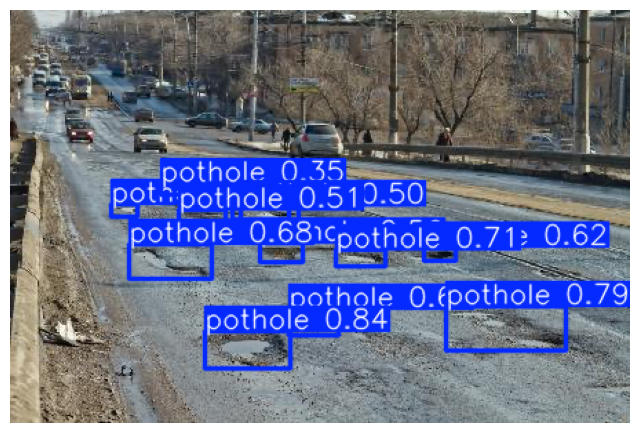

In [12]:
predict_and_show('/kaggle/input/pothole-detection/images/potholes0.png')